In [1]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

import datetime

import matplotlib.pyplot as pyplot
import seaborn as sns


from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline

/tmp/ipykernel_62023/1102493270.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [3]:

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": [5.39077, 5.392571, 5.324686, 5.32367],
	"longitude": [-6.505318, -6.427247, -6.502779, -6.427451],
	"start_date": "1940-01-01",
	"end_date": "2023-12-31",
	"daily": ["weather_code", "temperature_2m_max", "temperature_2m_min", "temperature_2m_mean", "apparent_temperature_max", "apparent_temperature_min", "apparent_temperature_mean", "sunrise", "sunset", "daylight_duration", "sunshine_duration", "precipitation_sum", "rain_sum", "snowfall_sum", "precipitation_hours", "wind_speed_10m_max", "wind_gusts_10m_max", "wind_direction_10m_dominant", "shortwave_radiation_sum", "et0_fao_evapotranspiration"],
	"wind_speed_unit": "ms",
	"timezone": "GMT"
}
responses = openmeteo.weather_api(url, params=params)

In [4]:
# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

Coordinates 5.3778557777404785°E -6.481781005859375°N
Elevation 109.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


In [5]:
# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_weather_code = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_max = daily.Variables(1).ValuesAsNumpy()
daily_temperature_2m_min = daily.Variables(2).ValuesAsNumpy()
daily_temperature_2m_mean = daily.Variables(3).ValuesAsNumpy()
daily_apparent_temperature_max = daily.Variables(4).ValuesAsNumpy()
daily_apparent_temperature_min = daily.Variables(5).ValuesAsNumpy()
daily_apparent_temperature_mean = daily.Variables(6).ValuesAsNumpy()
daily_sunrise = daily.Variables(7).ValuesAsNumpy()
daily_sunset = daily.Variables(8).ValuesAsNumpy()
daily_daylight_duration = daily.Variables(9).ValuesAsNumpy()
daily_sunshine_duration = daily.Variables(10).ValuesAsNumpy()
daily_precipitation_sum = daily.Variables(11).ValuesAsNumpy()
daily_rain_sum = daily.Variables(12).ValuesAsNumpy()
daily_snowfall_sum = daily.Variables(13).ValuesAsNumpy()
daily_precipitation_hours = daily.Variables(14).ValuesAsNumpy()
daily_wind_speed_10m_max = daily.Variables(15).ValuesAsNumpy()
daily_wind_gusts_10m_max = daily.Variables(16).ValuesAsNumpy()
daily_wind_direction_10m_dominant = daily.Variables(17).ValuesAsNumpy()
daily_shortwave_radiation_sum = daily.Variables(18).ValuesAsNumpy()
daily_et0_fao_evapotranspiration = daily.Variables(19).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s"),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s"),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["weather_code"] = daily_weather_code
daily_data["temperature_2m_max"] = daily_temperature_2m_max
daily_data["temperature_2m_min"] = daily_temperature_2m_min
daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
daily_data["apparent_temperature_max"] = daily_apparent_temperature_max
daily_data["apparent_temperature_min"] = daily_apparent_temperature_min
daily_data["apparent_temperature_mean"] = daily_apparent_temperature_mean
daily_data["sunrise"] = daily_sunrise
daily_data["sunset"] = daily_sunset
daily_data["daylight_duration"] = daily_daylight_duration
daily_data["sunshine_duration"] = daily_sunshine_duration
daily_data["precipitation_sum"] = daily_precipitation_sum
daily_data["rain_sum"] = daily_rain_sum
daily_data["snowfall_sum"] = daily_snowfall_sum
daily_data["precipitation_hours"] = daily_precipitation_hours
daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
daily_data["wind_gusts_10m_max"] = daily_wind_gusts_10m_max
daily_data["wind_direction_10m_dominant"] = daily_wind_direction_10m_dominant
daily_data["shortwave_radiation_sum"] = daily_shortwave_radiation_sum
daily_data["et0_fao_evapotranspiration"] = daily_et0_fao_evapotranspiration

daily_dataframe = pd.DataFrame(data = daily_data)


In [6]:
daily_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30681 entries, 0 to 30680
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         30681 non-null  datetime64[ns]
 1   weather_code                 30681 non-null  float32       
 2   temperature_2m_max           30681 non-null  float32       
 3   temperature_2m_min           30681 non-null  float32       
 4   temperature_2m_mean          30681 non-null  float32       
 5   apparent_temperature_max     30681 non-null  float32       
 6   apparent_temperature_min     30681 non-null  float32       
 7   apparent_temperature_mean    30681 non-null  float32       
 8   sunrise                      30681 non-null  int64         
 9   sunset                       30681 non-null  int64         
 10  daylight_duration            30681 non-null  float32       
 11  sunshine_duration            30680 non-nu

In [7]:
daily_dataframe.dropna(inplace=True)
#Remove NA (should only be 1 line for 01/01/1940)

In [8]:
daily_dataframe.iloc[16554]

date                           1985-04-29 00:00:00
weather_code                                  63.0
temperature_2m_max                       30.967501
temperature_2m_min                         22.8675
temperature_2m_mean                      25.877916
apparent_temperature_max                 37.503307
apparent_temperature_min                  27.52281
apparent_temperature_mean                 31.06517
sunrise                                          0
sunset                                           0
daylight_duration                     44286.085938
sunshine_duration                     36364.222656
precipitation_sum                              4.1
rain_sum                                       4.1
snowfall_sum                                   0.0
precipitation_hours                            2.0
wind_speed_10m_max                        2.828427
wind_gusts_10m_max                             6.1
wind_direction_10m_dominant             227.459045
shortwave_radiation_sum        

In [9]:
def day_decade(date):
    if date.day == 31 :
        return 1 + (date.month - 1) * 3 + 2
    else :
        return 1 + (date.month - 1) * 3 + (date.day - 1) // 10

In [10]:
daily_dataframe['daily_decade'] = daily_dataframe['date'].apply(lambda date : 1 + (date.month - 1) * 3 + (date.day - 1) // 10 if date.day < 31 else 1 + (date.month - 1) * 3 + 2)

In [11]:
daily_dataframe.set_index(['date'], inplace=True)

In [12]:
daily_dataframe['last_year'] = daily_dataframe.index.year == 2023

In [13]:
daily_dataframe[daily_dataframe.index.day ==1]["daily_decade"]

date
1940-02-01     4
1940-03-01     7
1940-04-01    10
1940-05-01    13
1940-06-01    16
              ..
2023-08-01    22
2023-09-01    25
2023-10-01    28
2023-11-01    31
2023-12-01    34
Name: daily_decade, Length: 1007, dtype: int64

In [14]:
daily_dataframe.head()

,weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,daylight_duration,...,rain_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration,daily_decade,last_year
date,,,,,,,,,,,,,,,,,,,,,
1940-01-02,61.0,28.237000,21.337000,23.434919,33.610329,25.092930,27.586264,0,0,42542.132812,...,5.3,0.0,8.0,2.080865,6.9,207.241623,12.71,2.599318,1,False
1940-01-03,53.0,27.337000,20.487000,22.797417,32.439350,23.774258,26.755369,0,0,42546.742188,...,0.7,0.0,2.0,2.402082,6.1,229.969818,12.20,2.437216,1,False
1940-01-04,3.0,28.437000,21.286999,23.839081,32.152454,24.864700,27.387369,0,0,42551.699219,...,0.0,0.0,0.0,2.517936,5.3,229.524826,13.36,2.777272,1,False
1940-01-05,51.0,29.386999,20.837000,24.401581,33.673237,24.317430,28.035353,0,0,42557.000000,...,0.4,0.0,3.0,2.828427,5.9,228.576416,17.50,3.591920,1,False
1940-01-06,51.0,29.437000,22.187000,24.645332,34.418110,25.935972,28.748156,0,0,42562.636719,...,0.6,0.0,5.0,2.302173,4.9,211.099960,16.50,3.396649,1,False


In [15]:
historical_daily = daily_dataframe[daily_dataframe.index.year < 2023]
last_year = daily_dataframe[daily_dataframe.index.year == 2023]

In [16]:
d = datetime.date(2023, 6, 1)
d

datetime.date(2023, 6, 1)

In [17]:
daily_dataframe[daily_dataframe['daily_decade'] == day_decade(d)]

,weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,daylight_duration,...,rain_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration,daily_decade,last_year
date,,,,,,,,,,,,,,,,,,,,,
1940-06-01,63.0,28.837000,21.937000,23.945333,34.146664,25.858616,28.082754,0,0,44689.054688,...,12.900000,0.0,10.0,3.178050,8.1,238.888718,15.290000,3.021018,16,False
1940-06-02,63.0,28.987000,21.737000,24.359915,33.720638,25.327698,28.422239,0,0,44696.101562,...,5.699999,0.0,9.0,2.785677,7.1,235.571991,17.139999,3.395510,16,False
1940-06-03,63.0,27.636999,22.036999,23.834915,31.797707,26.127277,27.713152,0,0,44702.824219,...,9.000001,0.0,6.0,3.324154,8.1,215.749725,13.170000,2.571385,16,False
1940-06-04,63.0,28.187000,21.286999,24.326584,32.730858,25.047041,28.407600,0,0,44709.210938,...,10.800000,0.0,9.0,2.758623,6.7,218.104721,18.080000,3.557429,16,False
1940-06-05,63.0,28.136999,22.036999,23.847418,32.066998,25.879406,27.796869,0,0,44715.257812,...,11.600000,0.0,8.0,2.773085,5.8,207.090057,12.070000,2.412807,16,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-06,61.0,30.224001,23.224001,24.961500,34.984566,27.963303,29.624403,0,0,44716.734375,...,9.100000,0.0,9.0,3.313608,8.1,211.666122,10.760000,2.232282,16,True
2023-06-07,65.0,27.374001,22.574001,23.942749,31.774498,27.413208,28.737068,0,0,44722.226562,...,29.900003,0.0,18.0,2.523886,8.2,218.382004,8.860000,1.767278,16,True
2023-06-08,63.0,26.974001,22.024000,24.024000,31.606846,26.445978,28.810526,0,0,44727.359375,...,8.999999,0.0,17.0,3.324154,8.1,198.795364,9.860000,1.940799,16,True


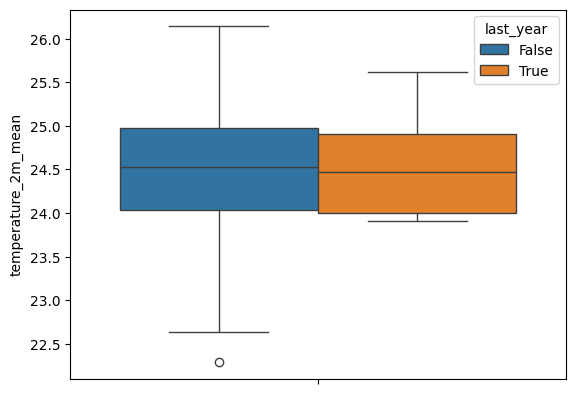

In [18]:
sns.boxplot(daily_dataframe[daily_dataframe['daily_decade'] == day_decade(d)], y="temperature_2m_mean", hue = "last_year");

In [28]:
studied_cols = ["last_year",
                #"daily_decade",
                #"weather_code", 
                "temperature_2m_max", 
                "temperature_2m_min", 
                "temperature_2m_mean", 
                #"apparent_temperature_max", 
                #"apparent_temperature_min", 
                #"apparent_temperature_mean", 
                #"sunrise", 
                #"sunset", 
                #"daylight_duration", 
                #"sunshine_duration", 
                "precipitation_sum", 
                #"rain_sum", 
                #"snowfall_sum", 
                "precipitation_hours", 
                #"wind_speed_10m_max", 
                "wind_gusts_10m_max", 
                #"wind_direction_10m_dominant", 
                "shortwave_radiation_sum", 
                "et0_fao_evapotranspiration"]

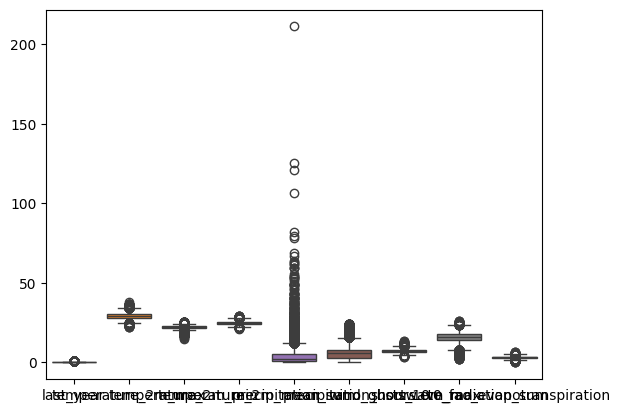

In [29]:
sns.boxplot(daily_dataframe[studied_cols]);#, hue="last_year");